<a href="https://colab.research.google.com/github/Contactashmeetsingh/waymo-mtr-/blob/main/waymomtrashmeet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os

# 1. Undo my broken patch by restoring the original file
os.system("cd /content/MTR && git checkout mtr/datasets/waymo/waymo_dataset.py")

# 2. Read the restored file
file_path = '/content/MTR/mtr/datasets/waymo/waymo_dataset.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

# 3. Apply a perfectly indented, safe patch
with open(file_path, 'w') as file:
    for line in lines:
        if 'from .waymo_eval import waymo_evaluation' in line:
            # Dynamically grab the exact spaces used in the original line
            indent = line[:len(line) - len(line.lstrip())]

            # Inject the bypass with perfect indentation
            file.write(f"{indent}return 'Waymo Evaluation Skipped', {{}}\n")
            file.write(f"{indent}# {line.lstrip()}") # Comment out the broken import
        else:
            file.write(line)

print("✅ File successfully restored and perfectly patched! You are ready to train.")

✅ File successfully restored and perfectly patched! You are ready to train.


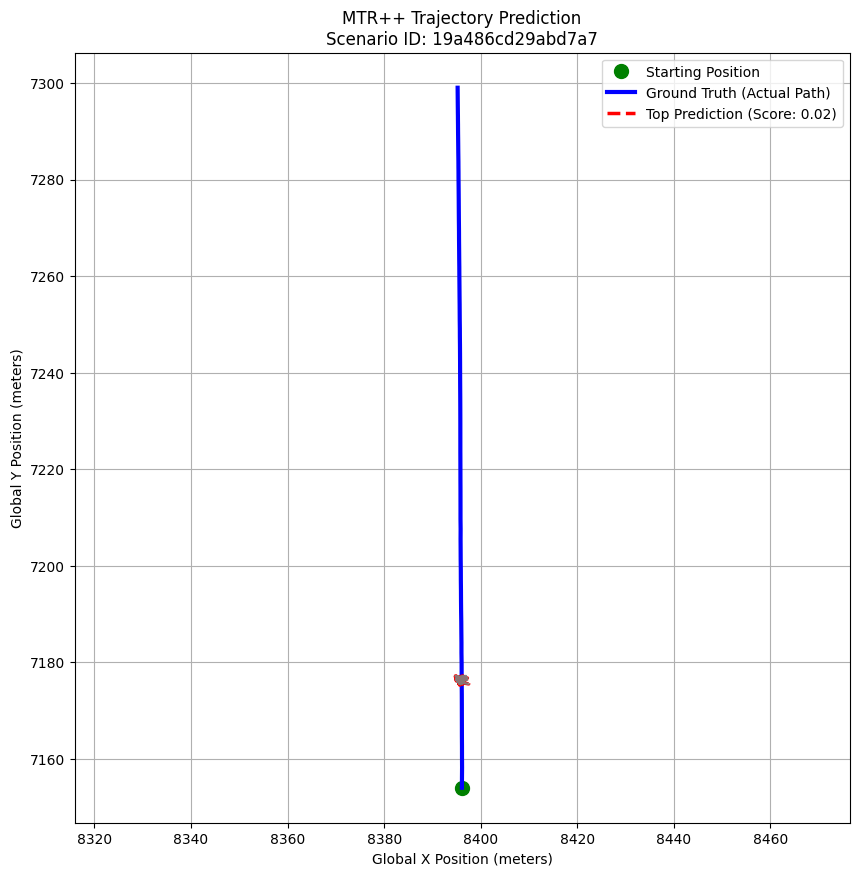

In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_mtr_predictions(eval_pkl_path, sample_index=0):
    if not os.path.exists(eval_pkl_path):
        print(f"❌ Could not find prediction file at {eval_pkl_path}")
        return

    # Load and flatten the predictions
    with open(eval_pkl_path, 'rb') as f:
        raw_data = pickle.load(f)

    flat_predictions = []
    if isinstance(raw_data, list):
        for item in raw_data:
            if isinstance(item, list):
                flat_predictions.extend(item)
            elif isinstance(item, dict):
                flat_predictions.append(item)
    elif isinstance(raw_data, dict):
        flat_predictions = list(raw_data.values())

    scene = flat_predictions[sample_index]

    scenario_id = scene.get('scenario_id', 'Unknown')
    pred_trajs = scene.get('pred_trajs', None)
    pred_scores = scene.get('pred_scores', None)
    gt_trajs = scene.get('gt_trajs', None)

    plt.figure(figsize=(10, 10))
    plt.title(f"MTR++ Trajectory Prediction\nScenario ID: {scenario_id}")

    # 1. Find the true starting position (First point of the ground truth)
    if gt_trajs is not None and len(gt_trajs) > 0:
        start_x, start_y = gt_trajs[0, 0], gt_trajs[0, 1]
        plt.plot(start_x, start_y, 'go', markersize=10, label='Starting Position')
        # Plot Ground Truth
        plt.plot(gt_trajs[:, 0], gt_trajs[:, 1], 'b-', linewidth=3, label='Ground Truth (Actual Path)')
    else:
        # Fallback if ground truth is missing
        start_x, start_y = pred_trajs[0, 0, 0], pred_trajs[0, 0, 1]
        plt.plot(start_x, start_y, 'go', markersize=10, label='Starting Position')

    # 2. Identify the highest-confidence prediction
    best_mode_idx = np.argmax(pred_scores)
    best_traj = pred_trajs[best_mode_idx]

    # Plot the best prediction (Red Dashed Line)
    plt.plot(best_traj[:, 0], best_traj[:, 1], 'r--', linewidth=2.5,
             label=f'Top Prediction (Score: {pred_scores[best_mode_idx]:.2f})')

    # 3. Plot the alternative predictions (Faint Gray Lines)
    for i in range(len(pred_trajs)):
        if i != best_mode_idx:
            plt.plot(pred_trajs[i, :, 0], pred_trajs[i, :, 1], 'gray', alpha=0.4, linestyle='--')

    plt.xlabel("Global X Position (meters)")
    plt.ylabel("Global Y Position (meters)")
    plt.legend()
    plt.grid(True)

    # Force the graph to scale properly to the actual paths
    plt.axis('equal')
    plt.show()

# Run the fixed visualizer!
visualize_mtr_predictions('/content/MTR/output/waymo/mtr+20_percent_data/my_first_run/eval/eval_with_train/epoch_1/result.pkl', sample_index=0)

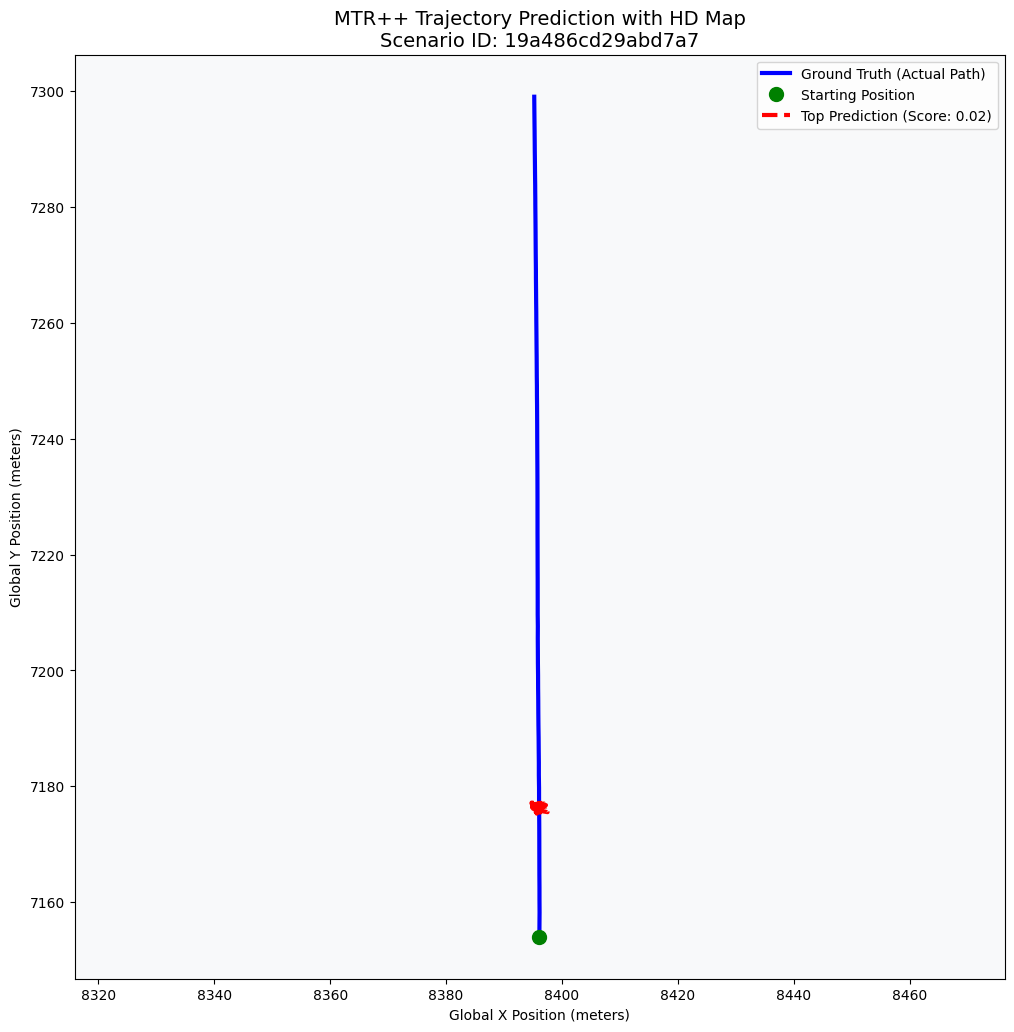

Target Scenario ID to match: 19a486cd29abd7a7


In [26]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_mtr_with_map(eval_pkl_path, train_dir, val_dir, sample_index=0):
    with open(eval_pkl_path, 'rb') as f:
        raw_data = pickle.load(f)

    flat_predictions = []
    if isinstance(raw_data, list):
        for item in raw_data:
            if isinstance(item, list):
                flat_predictions.extend(item)
            elif isinstance(item, dict):
                flat_predictions.append(item)

    scene = flat_predictions[sample_index]
    scenario_id = scene.get('scenario_id', 'Unknown')
    pred_trajs = scene.get('pred_trajs', None)
    pred_scores = scene.get('pred_scores', None)
    gt_trajs = scene.get('gt_trajs', None)

    # --- FIX: Search both folders for the map ---
    map_file = os.path.join(train_dir, f'sample_{scenario_id}.pkl')
    if not os.path.exists(map_file):
        map_file = os.path.join(val_dir, f'sample_{scenario_id}.pkl')

    if not os.path.exists(map_file):
        print(f"❌ Could not find the map file for {scenario_id} anywhere!")
        return

    with open(map_file, 'rb') as f:
        map_data = pickle.load(f)

    plt.figure(figsize=(12, 12))
    plt.title(f"MTR++ Trajectory Prediction with HD Map\nScenario ID: {scenario_id}", fontsize=14)

    # 1. Plot the Road Map Background
    if 'map_features' in map_data:
        map_features = map_data['map_features']
        for i in range(map_features.shape[0]):
            line = map_features[i]
            valid_mask = (line[:, 0] != 0) | (line[:, 1] != 0)
            valid_pts = line[valid_mask]
            if len(valid_pts) > 1:
                plt.plot(valid_pts[:, 0], valid_pts[:, 1], color='#D3D3D3', linewidth=1.5, zorder=1)

    # 2. Plot the Actual Future (Blue Line)
    if gt_trajs is not None and len(gt_trajs) > 0:
        plt.plot(gt_trajs[:, 0], gt_trajs[:, 1], 'b-', linewidth=3, label='Ground Truth (Actual Path)', zorder=3)
        plt.plot(gt_trajs[0, 0], gt_trajs[0, 1], 'go', markersize=10, label='Starting Position', zorder=4)

    # 3. Plot the MTR Predictions (Red and Pink)
    best_mode_idx = np.argmax(pred_scores)

    for i in range(len(pred_trajs)):
        if i == best_mode_idx:
            plt.plot(pred_trajs[i, :, 0], pred_trajs[i, :, 1], 'r--', linewidth=3,
                     label=f'Top Prediction (Score: {pred_scores[i]:.2f})', zorder=4)
        else:
            plt.plot(pred_trajs[i, :, 0], pred_trajs[i, :, 1], 'salmon', alpha=0.5, linestyle='--', zorder=2)

    plt.xlabel("Global X Position (meters)")
    plt.ylabel("Global Y Position (meters)")
    plt.legend(loc="upper right")
    plt.grid(False)
    plt.axis('equal')
    plt.gca().set_facecolor('#F8F9FA')
    plt.show()

    # Return the scenario ID so we can feed it to the raw visualizer next!
    return scenario_id

# Run it!
eval_path = '/content/MTR/output/waymo/mtr+20_percent_data/my_first_run/eval/eval_with_train/epoch_1/result.pkl'
train_dir = '/content/MTR/data/waymo/processed_scenarios_training'
val_dir = '/content/MTR/data/waymo/processed_scenarios_validation'

# Save the ID it processes
target_scenario = visualize_mtr_with_map(eval_path, train_dir, val_dir, sample_index=0)
print(f"Target Scenario ID to match: {target_scenario}")

Loading raw Waymo TFRecord from /content/MTR/data/waymo/scenario/training/training.tfrecord-00000-of-01000...


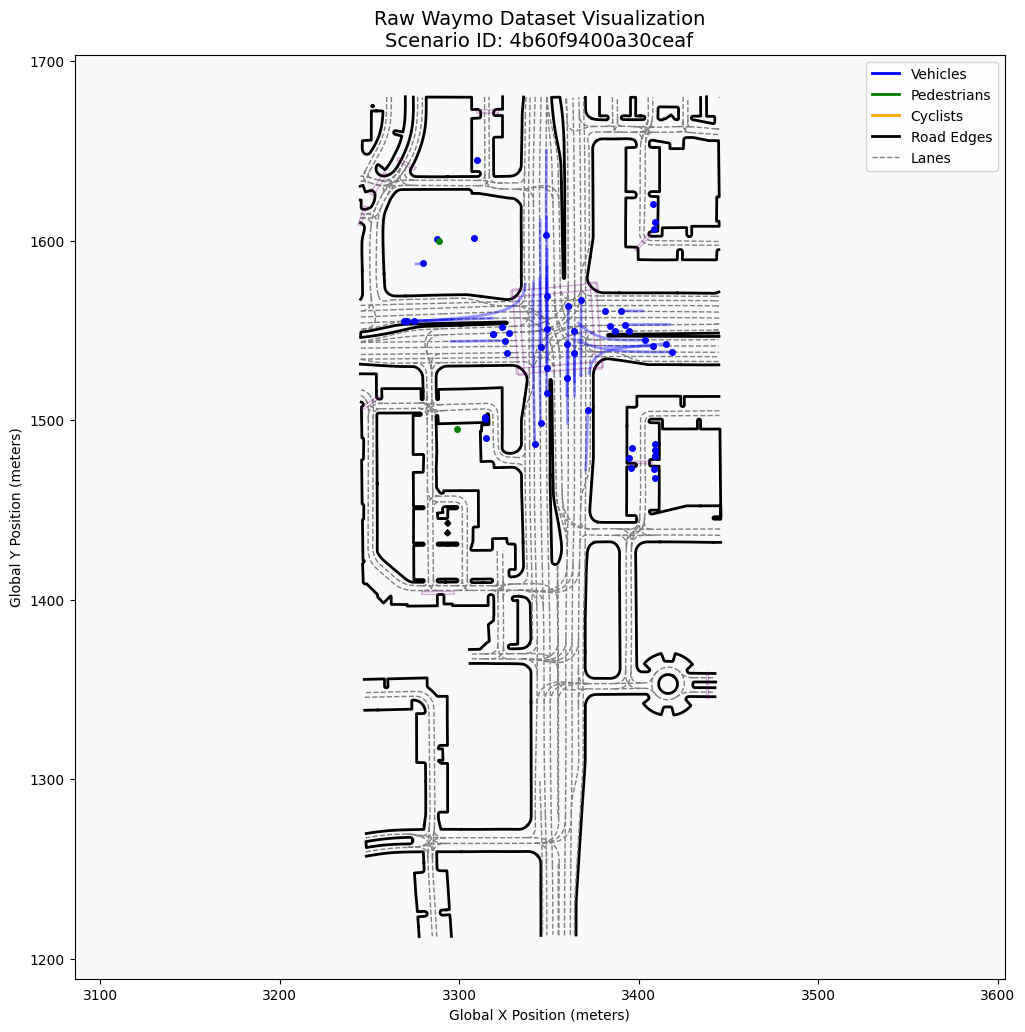

In [25]:
import tensorflow as tf
from waymo_open_dataset.protos import scenario_pb2
import matplotlib.pyplot as plt
import os

def visualize_raw_waymo_tfrecord(tfrecord_path, scenario_index=0):
    if not os.path.exists(tfrecord_path):
        print(f"❌ Could not find raw TFRecord file at {tfrecord_path}")
        return

    print(f"Loading raw Waymo TFRecord from {tfrecord_path}...")
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type='')

    scenario = scenario_pb2.Scenario()

    # Fast-forward to the requested scenario
    for i, data in enumerate(dataset):
        if i == scenario_index:
            scenario.ParseFromString(bytearray(data.numpy()))
            break

    plt.figure(figsize=(12, 12))
    plt.title(f"Raw Waymo Dataset Visualization\nScenario ID: {scenario.scenario_id}", fontsize=14)

    # 1. Plot the HD Map directly from Waymo's raw Protobuf definitions
    for feature in scenario.map_features:
        if feature.HasField('lane'):
            pts = [(pt.x, pt.y) for pt in feature.lane.polyline]
            xs, ys = zip(*pts)
            plt.plot(xs, ys, color='gray', linestyle='dashed', linewidth=1, zorder=1)
        elif feature.HasField('road_edge'):
            pts = [(pt.x, pt.y) for pt in feature.road_edge.polyline]
            xs, ys = zip(*pts)
            plt.plot(xs, ys, color='black', linewidth=2, zorder=1)
        elif feature.HasField('crosswalk'):
            pts = [(pt.x, pt.y) for pt in feature.crosswalk.polygon]
            if pts:
                pts.append(pts[0]) # Close the loop
                xs, ys = zip(*pts)
                plt.plot(xs, ys, color='purple', alpha=0.3, linewidth=1, zorder=1)

    # 2. Plot all the Agents (Vehicles, Pedestrians, Cyclists)
    for track in scenario.tracks:
        # Extract valid x,y coordinates across the full 9-second clip
        valid_xs = [state.center_x for state in track.states if state.valid]
        valid_ys = [state.center_y for state in track.states if state.valid]

        if len(valid_xs) == 0:
            continue

        # Color code by object type
        if track.object_type == scenario_pb2.Track.TYPE_VEHICLE:
            color = 'blue'
        elif track.object_type == scenario_pb2.Track.TYPE_PEDESTRIAN:
            color = 'green'
        elif track.object_type == scenario_pb2.Track.TYPE_CYCLIST:
            color = 'orange'
        else:
            color = 'cyan'

        # Draw the full history of the agent
        plt.plot(valid_xs, valid_ys, color=color, alpha=0.4, linewidth=2, zorder=2)
        # Draw a solid dot at their final position
        plt.plot(valid_xs[-1], valid_ys[-1], color=color, marker='o', markersize=4, zorder=3)

    plt.xlabel("Global X Position (meters)")
    plt.ylabel("Global Y Position (meters)")
    plt.grid(False)
    plt.axis('equal')
    plt.gca().set_facecolor('#F8F9FA')

    # Create a custom legend for clarity
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='blue', lw=2),
        Line2D([0], [0], color='green', lw=2),
        Line2D([0], [0], color='orange', lw=2),
        Line2D([0], [0], color='black', lw=2),
        Line2D([0], [0], color='gray', linestyle='dashed', lw=1)
    ]
    plt.legend(custom_lines, ['Vehicles', 'Pedestrians', 'Cyclists', 'Road Edges', 'Lanes'], loc='upper right')
    plt.show()

# Run the Raw Waymo Visualizer!
raw_tfrecord_path = '/content/MTR/data/waymo/scenario/training/training.tfrecord-00000-of-01000'
visualize_raw_waymo_tfrecord(raw_tfrecord_path, scenario_index=0)

Hunting for Scenario 19a486cd29abd7a7 in /content/MTR/data/waymo/scenario/validation/validation.tfrecord-00000-of-00150...


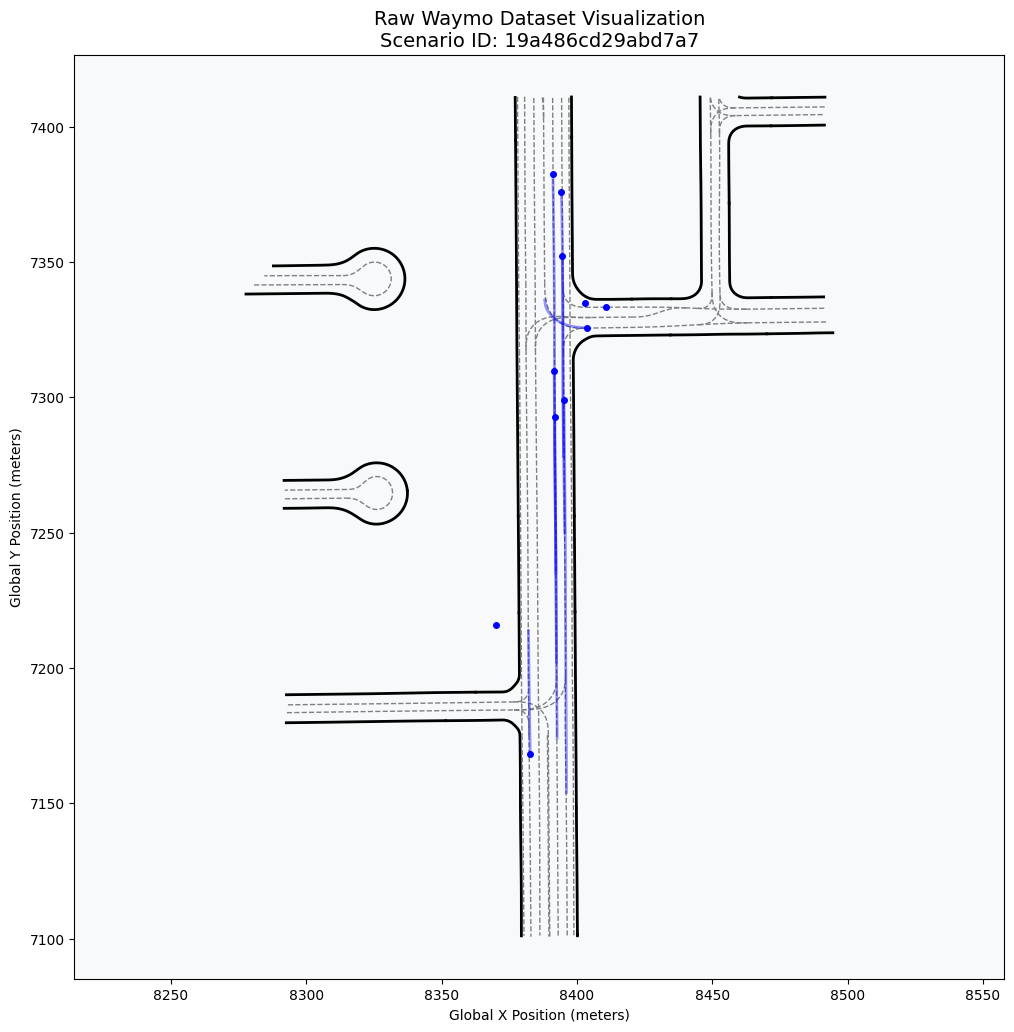

In [27]:
import tensorflow as tf
from waymo_open_dataset.protos import scenario_pb2
import matplotlib.pyplot as plt
import os

def visualize_specific_raw_waymo(tfrecord_path, target_id):
    print(f"Hunting for Scenario {target_id} in {tfrecord_path}...")
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type='')

    scenario = scenario_pb2.Scenario()
    found = False

    # Scan the file until we find the exact matching scenario
    for data in dataset:
        scenario.ParseFromString(bytearray(data.numpy()))
        if scenario.scenario_id == target_id:
            found = True
            break

    if not found:
        print(f"❌ Could not find {target_id} in this TFRecord!")
        return

    plt.figure(figsize=(12, 12))
    plt.title(f"Raw Waymo Dataset Visualization\nScenario ID: {scenario.scenario_id}", fontsize=14)

    # 1. Plot Map
    for feature in scenario.map_features:
        if feature.HasField('lane'):
            pts = [(pt.x, pt.y) for pt in feature.lane.polyline]
            xs, ys = zip(*pts)
            plt.plot(xs, ys, color='gray', linestyle='dashed', linewidth=1, zorder=1)
        elif feature.HasField('road_edge'):
            pts = [(pt.x, pt.y) for pt in feature.road_edge.polyline]
            xs, ys = zip(*pts)
            plt.plot(xs, ys, color='black', linewidth=2, zorder=1)

    # 2. Plot Agents
    for track in scenario.tracks:
        valid_xs = [state.center_x for state in track.states if state.valid]
        valid_ys = [state.center_y for state in track.states if state.valid]
        if len(valid_xs) == 0: continue

        if track.object_type == scenario_pb2.Track.TYPE_VEHICLE: color = 'blue'
        elif track.object_type == scenario_pb2.Track.TYPE_PEDESTRIAN: color = 'green'
        elif track.object_type == scenario_pb2.Track.TYPE_CYCLIST: color = 'orange'
        else: color = 'cyan'

        plt.plot(valid_xs, valid_ys, color=color, alpha=0.4, linewidth=2, zorder=2)
        plt.plot(valid_xs[-1], valid_ys[-1], color=color, marker='o', markersize=4, zorder=3)

    plt.xlabel("Global X Position (meters)")
    plt.ylabel("Global Y Position (meters)")
    plt.grid(False)
    plt.axis('equal')
    plt.gca().set_facecolor('#F8F9FA')
    plt.show()

# Point to the VALIDATION file because that's what the model evaluated
raw_val_tfrecord = '/content/MTR/data/waymo/scenario/validation/validation.tfrecord-00000-of-00150'

# Use the target ID printed by the first script!
# (Make sure this matches the output of the first cell)
visualize_specific_raw_waymo(raw_val_tfrecord, '19a486cd29abd7a7')